In [121]:
# %%capture
# %pip install pytorch-ignite

In [122]:
# from ignite.engine import Engine, Events
# from ignite.handlers import EarlyStopping
# from ignite.metrics import Loss
# from ignite.contrib.handlers import ProgressBar

In [123]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

from torch.utils.data import Dataset, random_split
from PIL import Image
from torchvision import transforms

from google.colab import drive
drive.mount('/content/drive')

# make sure you have this Math156 folder or you may have to change this to ur current directory
os.chdir('/content/drive/MyDrive/Colab Notebooks/Math156')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading and preprocessing data

In [124]:
class PoseDataset(Dataset):
    def __init__(self, annotation_file, root_dir, transform=None):
        self.annotations = []
        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 2:
                    continue  # skip invalid lines

                img_path = parts[0]
                try:
                    target = list(map(float, parts[1:]))
                except ValueError:
                    continue  # skip lines with non-numeric targets

                self.annotations.append((img_path, torch.tensor(target, dtype=torch.float32)))

        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_rel_path, target = self.annotations[idx]
        img_path = os.path.join(self.root_dir, img_rel_path)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, target

## Channel Attention Module

In [125]:
# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # [C,1,1]
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_MLP = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_MLP(self.avg_pool(x))
        max_out = self.shared_MLP(self.max_pool(x))
        return self.sigmoid(avg_out + max_out) * x

## Spatial Attention Module

In [126]:
# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        kernel_size=KERNAL_SIZE
        padding = (kernel_size - 1) // 2

        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)         # [B,1,H,W]
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)         # [B,2,H,W]
        return self.sigmoid(self.conv(x_cat)) * x

## CBAM

In [127]:
# Combined CBAM
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

## Convolutional Block / Layer with CBAM

In [128]:
class BasicBlockWithCBAM(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.cbam = CBAM(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out = self.cbam(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

## PoseRegressor

In [129]:
class PoseRegressor(nn.Module):
    """ A simple MLP to regress a pose component"""

    def __init__(self, decoder_dim, output_dim, use_prior=False):
        """
        decoder_dim: (int) the input dimension
        output_dim: (int) the outpur dimension
        use_prior: (bool) whether to use prior information
        """
        super().__init__()
        ch = 1024
        self.fc_h = nn.Linear(decoder_dim, ch)
        self.use_prior = use_prior
        if self.use_prior:
            self.fc_h_prior = nn.Linear(decoder_dim * 2, ch)
        self.fc_o = nn.Linear(ch, output_dim)
        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        """
        Forward pass
        """
        if self.use_prior:
            x = F.gelu(self.fc_h_prior(x))
        else:
            x = F.gelu(self.fc_h(x))

        return self.fc_o(x)

## PoseLoss

In [130]:
class CameraPoseLoss(nn.Module):
    """
    A class to represent camera pose loss with optional learnable weights.
    """

    def __init__(self, config):
        """
        :param config: (dict) Configuration dictionary with keys:
            - "learnable": (bool) Whether s_x and s_q are learnable
            - "s_x": (float) Initial weight for position loss
            - "s_q": (float) Initial weight for orientation loss
            - "norm": (int or float) Norm type for distance (1 for L1, 2 for L2, etc.)
        """
        super(CameraPoseLoss, self).__init__()
        self.learnable = config.get("learnable", False)
        self.norm = config.get("norm", 2)

        s_x = torch.tensor([config.get("s_x")], dtype=torch.float32)
        s_q = torch.tensor([config.get("s_q")], dtype=torch.float32)

        self.s_x = nn.Parameter(s_x, requires_grad=self.learnable)
        self.s_q = nn.Parameter(s_q, requires_grad=self.learnable)

    def forward(self, est_pose, gt_pose):
        """
        Compute the camera pose loss.

        :param est_pose: (torch.Tensor) Nx7 estimated pose tensor
        :param gt_pose: (torch.Tensor) Nx7 ground truth pose tensor
        :return: l_x, l_q, total_loss
        """
        # Position loss
        l_x = torch.norm(gt_pose[:, :3] - est_pose[:, :3], p=self.norm, dim=1).mean()

        # Orientation loss using normalized quaternions
        est_q = F.normalize(est_pose[:, 3:], p=2, dim=1)
        gt_q = F.normalize(gt_pose[:, 3:], p=2, dim=1)
        l_q = torch.norm(gt_q - est_q, p=self.norm, dim=1).mean()

        # Total loss
        if self.learnable:
            total_loss = l_x * torch.exp(-self.s_x) + self.s_x + l_q * torch.exp(-self.s_q) + self.s_q
        else:
            total_loss = self.s_x * l_x + self.s_q * l_q

        return total_loss

## ResNet with CBAM

In [131]:
class ResNetCBAM(nn.Module):
    def __init__(self, block, layers, pos_dim=3, orien_dim=4):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.pos_fc = PoseRegressor(512 * block.expansion, pos_dim)
        self.orien_fc = PoseRegressor(512 * block.expansion, orien_dim)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)  # -> [B, 64, H/4, W/4]
        x = self.layer2(x)  # -> [B, 128, H/8, W/8]
        x = self.layer3(x)  # -> [B, 256, H/16, W/16]
        x = self.layer4(x)  # -> [B, 512, H/32, W/32]

        x = self.avgpool(x)  # -> [B, 512, 1, 1]
        x = torch.flatten(x, 1)

        # → regression output
        position = self.pos_fc(x)
        orientation = self.orien_fc(x)

        return torch.cat([position, orientation], dim=1)

## Train and validation data split

In [132]:
full_dataset = PoseDataset(annotation_file='KingsCollege/dataset_train.txt', root_dir='KingsCollege')

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [133]:
config = {
    "learnable": True,
    "s_x": 0.0,
    "s_q": -3.0,
    "norm": 2
}

criterion = CameraPoseLoss(config)

## Train model

In [134]:
training_loss_tracker = []
validation_loss_tracker = []

model = ResNetCBAM(BasicBlockWithCBAM, [2, 2, 2, 2], pos_dim=3, orien_dim=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

# Adam
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(criterion.parameters()),
    lr=1e-4
)

# Early stopping parameters
patience = 10
min_delta = 0.001
best_val_loss = float('inf')
epochs_no_improve = 0


# Train
for epoch in range(100):
    model.train()
    training_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        est_pose = model(imgs)
        loss = criterion(est_pose, labels)

        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    avg_training_loss = training_loss / len(train_loader)
    training_loss_tracker.append(avg_training_loss)

    # Validation
    model.eval()
    validation_loss = 0.0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            est_pose = model(imgs)

            val_loss = criterion(est_pose, labels)
            validation_loss += val_loss.item()

    avg_validation_loss = validation_loss / len(val_loader)
    validation_loss_tracker.append(avg_validation_loss)

    print(f"Epoch {epoch + 1}: Training Loss = {avg_training_loss:.4f}  Validation Loss = {avg_validation_loss:.4f} s_x = {criterion.s_x.item():.4f}  s_q = {criterion.s_q.item():.4f}")

    # Early stopping check
    if avg_validation_loss < best_val_loss - min_delta:
        best_val_loss = avg_validation_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

Epoch 1: Training Loss = 38.0917  Validation Loss = 38.7399 s_x = 0.0030  s_q = -2.9983
Epoch 2: Training Loss = 17.3213  Validation Loss = 27.1847 s_x = 0.0051  s_q = -2.9975
Epoch 3: Training Loss = 9.6006  Validation Loss = 6.6700 s_x = 0.0065  s_q = -2.9968
Epoch 4: Training Loss = 7.1426  Validation Loss = 5.3270 s_x = 0.0076  s_q = -2.9962
Epoch 5: Training Loss = 5.8660  Validation Loss = 5.0478 s_x = 0.0087  s_q = -2.9957
Epoch 6: Training Loss = 4.8027  Validation Loss = 8.1314 s_x = 0.0096  s_q = -2.9953
Epoch 7: Training Loss = 4.2421  Validation Loss = 7.2186 s_x = 0.0107  s_q = -2.9948
Epoch 8: Training Loss = 3.4475  Validation Loss = 2.8237 s_x = 0.0116  s_q = -2.9945
Epoch 9: Training Loss = 3.4743  Validation Loss = 3.6361 s_x = 0.0125  s_q = -2.9942
Epoch 10: Training Loss = 3.6809  Validation Loss = 2.4984 s_x = 0.0136  s_q = -2.9940
Epoch 11: Training Loss = 2.9861  Validation Loss = 3.9958 s_x = 0.0146  s_q = -2.9939
Epoch 12: Training Loss = 3.4252  Validation Los

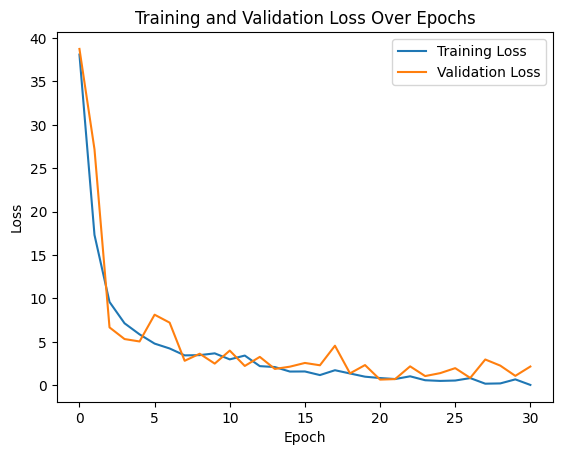

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(len(training_loss_tracker)), y=training_loss_tracker, label='Training Loss')
sns.lineplot(x=range(len(validation_loss_tracker)), y=validation_loss_tracker, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [142]:
# torch.save(model.state_dict(), 'resnet_cbam_pose_regressor.pth')

# loss_config = {
#     "learnable": criterion.learnable,
#     "s_x": criterion.s_x.item(),
#     "s_q": criterion.s_q.item(),
#     "norm": criterion.norm
# }
# torch.save(loss_config, 'camera_pose_loss_config.pth')

In [ ]:
# loss_config = torch.load('camera_pose_loss_config.pth')
# loaded_criterion = CameraPoseLoss(loss_config)

# loaded_model = ResNetCBAM(BasicBlockWithCBAM, [2, 2, 2, 2], pos_dim=3, orien_dim=4)

# loaded_model.load_state_dict(torch.load('resnet_cbam_pose_regressor.pth'))

# loaded_model = loaded_model.to(device)
# loaded_criterion = loaded_criterion.to(device)

In [136]:
# # I want to tried the early stopping but it does not stop

# # Model setup
# model = ResNetCBAM(BasicBlockWithCBAM, [2, 2, 2, 2], pos_dim=3, orien_dim=4)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# # --- Define training step ---
# def train_step(engine, batch):
#     model.train()
#     imgs, labels = batch
#     imgs, labels = imgs.to(device), labels.to(device)
#     optimizer.zero_grad()
#     outputs = model(imgs)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()
#     # Return outputs and labels for the Loss metric
#     return outputs, labels

# # --- Define evaluation step ---
# def eval_step(engine, batch):
#     model.eval()
#     with torch.no_grad():
#         imgs, labels = batch
#         imgs, labels = imgs.to(device), labels.to(device)
#         outputs = model(imgs)
#         return outputs, labels

# # Create trainer and evaluator
# trainer = Engine(train_step)
# evaluator = Engine(eval_step)

# # Attach metrics
# # The Loss metric for the trainer will now receive outputs and labels
# Loss(criterion).attach(trainer, "train_loss")
# Loss(criterion).attach(evaluator, "val_loss")

# # Early stopping
# def score_function(engine):
#     return -engine.state.metrics["val_loss"]  # Lower loss = higher score

# early_stopping = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# evaluator.add_event_handler(Events.COMPLETED, early_stopping)

# # Progress bar
# ProgressBar().attach(trainer)

# # Logging both training and validation loss
# @trainer.on(Events.EPOCH_COMPLETED)
# def log_results(engine):
#     train_loss = engine.state.metrics["train_loss"]
#     evaluator.run(val_loader)
#     val_loss = evaluator.state.metrics["val_loss"]
#     print(f"Epoch {engine.state.epoch} - Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")

# # Start training
# trainer.run(train_loader, max_epochs=100)

## Test model

In [137]:
test_dataset = PoseDataset(annotation_file='KingsCollege/dataset_test.txt', root_dir='KingsCollege')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [138]:
model.eval()  # Set model to evaluation mode once

test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation globally
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        all_preds.append(outputs.cpu())
        all_labels.append(labels.cpu())

test_loss /= len(test_loader)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

print(f"Test Loss: {test_loss:.4f}")

Test Loss: 3.4098
